# Import libraries

In [ ]:
import sys
sys.path.insert(0,'..')

In [ ]:
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from src.datasets.rb_fpa_prim_quench_ee_plateau import RBFPAPrimQuenchEEPlateau
from src.datasets.rb_fpa_prim_quench_ee_plateau2 import RBFPAPrimQuenchEEPlateau2
from src.utils.frequency_utils import get_fft_of_DataArray
from src.visualisation.fft_visualisation import plot_nmf_components, plot_position_frequency_map, plot_nmf_event_composition, plot_avg_component_weight
from src.utils.utils import merge_array
from src.utils.sort_utils import map_position_index, main_mirror_to_el, generate_sorted_value_dict

pd.set_option('display.max_rows', 200)
import warnings
warnings.filterwarnings('ignore')

# Define Paths

In [ ]:
file_path  = Path('/eos/project/m/ml-for-alarm-system/private/RB_signals')
data_path = file_path / 'backup/20220707_data'
simulation_path = file_path / 'backup/20220707_simulation'

# Read the (clean) MP3 file

In [ ]:
mp3_fpa_df = pd.read_csv("../data/RB_TC_extract_2022_07_07_processed_filled.csv")
mp3_fpa_df_unique = mp3_fpa_df.drop_duplicates(subset=['fpa_identifier'])
len(mp3_fpa_df), len(mp3_fpa_df_unique)

# Read metadata

In [ ]:
metadata_path = Path("../data/RB_metadata.csv")
rb_magnet_metadata = pd.read_csv(metadata_path, index_col=False)
rb_magnet_metadata

# Read position map

In [ ]:
pos_map_path = Path("../data/circuit_sort.csv")
df_pos_map = pd.read_csv(pos_map_path)

In [ ]:
df_pos_map_show = df_pos_map[(df_pos_map["Circuit"] == 'RB.A12') & (df_pos_map["El. Quench Position"] == 0)].reset_index(drop=True)
value_columns = df_pos_map_show.filter(regex= ". ").columns
df_pos_map_show[value_columns] = (df_pos_map_show[value_columns] +1)
df_pos_map_show.T

In [ ]:
df_pos_map = df_pos_map.set_index(['Circuit', 'El. Quench Position', 'Phys. Quench Position']) # allows faster indexing

# Load Data

In [ ]:
dataset_path_1EE = Path("/eos/project/m/ml-for-alarm-system/private/RB_signals/backup/20220707_prim_ee_plateau_dataset")
dataset_path_2EE = Path("/eos/project/m/ml-for-alarm-system/private/RB_signals/backup/20220707_RBFPAPrimQuenchEEPlateau2")

dataset_creator_1EE = RBFPAPrimQuenchEEPlateau()
dataset_creator_2EE = RBFPAPrimQuenchEEPlateau2()

all_fpa_identifiers_mp3 = mp3_fpa_df[(mp3_fpa_df['timestamp_fgc'] > 1611836512820000000)].fpa_identifier.unique()
fpa_identifiers_fast_sec_quench = mp3_fpa_df[(mp3_fpa_df['Delta_t(iQPS-PIC)'] / 1000 < 5) & (mp3_fpa_df['Nr in Q event'].astype(str) !='1')].fpa_identifier.unique()
all_fpa_identifiers = all_fpa_identifiers_mp3[~np.isin(all_fpa_identifiers_mp3, fpa_identifiers_fast_sec_quench)]

dataset_1EE = dataset_creator_1EE.load_dataset(fpa_identifiers=all_fpa_identifiers,
                                       dataset_path=dataset_path_1EE,
                                       drop_data_vars=['simulation', 'el_position_feature', 'event_feature'])

dataset_2EE = dataset_creator_2EE.load_dataset(fpa_identifiers=all_fpa_identifiers,
                                       dataset_path=dataset_path_2EE,
                                       drop_data_vars=['simulation', 'el_position_feature', 'event_feature'])

max_freq = 360
dataset_1EE_fft = get_fft_of_DataArray(data=dataset_1EE.data, cutoff_frequency=max_freq)
dataset_2EE_fft = get_fft_of_DataArray(data=dataset_2EE.data, cutoff_frequency=max_freq)

# postprocess fft data
data_1EE_ff_scaled = np.array([dataset_creator_1EE.log_scale_data(x) for x in dataset_1EE_fft.data])
data_2EE_ff_scaled = np.array([dataset_creator_2EE.log_scale_data(x) for x in dataset_2EE_fft.data])
data_1EE = np.nan_to_num(data_1EE_ff_scaled.reshape(-1, np.shape(data_1EE_ff_scaled)[2]))
data_2EE = np.nan_to_num(data_2EE_ff_scaled.reshape(-1, np.shape(data_2EE_ff_scaled)[2]))

# Non-negative components - NMF

In [ ]:
fpa_identifiers = all_fpa_identifiers[np.isin(all_fpa_identifiers, dataset_1EE.event.values)]

use_fpa_identifier = True
if use_fpa_identifier:
    # provide fpa_identifier
    fpa_identifier = 'RB_RB.A78_1617170255140000000'
    event_idex = np.argmax(fpa_identifiers == fpa_identifier)
else: 
    # provide event_index 
    event_idex = 1 #30
    dataset_fft_cut = dataset_1EE_fft.loc[{'event': fpa_identifiers}]
    fpa_identifier =  dataset_fft_cut[{'event': event_idex}].event.values

date = mp3_fpa_df[mp3_fpa_df.fpa_identifier == fpa_identifier]['Timestamp_PIC'].values[0]
event_idex, fpa_identifier, date

## 1st Energy Extraction Plateau

In [ ]:
n_components = 10
W_1EE, H_1EE, n_iter = nmf_missing.non_negative_factorization(data_1EE, n_components=n_components, init='nndsvd', tol=1e-3, l1_ratio=0.5,  regularization='both', alpha=1)

In [ ]:
plot_nmf_components(H_1EE, dataset_1EE_fft)

In [ ]:
merge_component_index = np.arange(n_components) #[0, [2, 6], [1, 3, 4, 7, 8], 5, 9] #[0, 1, 2, 3, 4, 5, 6, 7, 8, 9] #
H_1EE_merged = merge_array(H_1EE.T, merge_component_index, axis=-1, func=np.sum).T
component_weights_1EE = merge_array(W_1EE, merge_component_index, axis=-1, func=np.mean)

max_H = H_1EE_merged.max(axis=1, keepdims=True)
H_1EE_processed = H_1EE_merged / max_H
component_weights_1EE = (component_weights_1EE * np.expand_dims(max_H.T, axis=0))[0]

### Check components

In [ ]:
component_indexes_1EE = [0, 1, 2, 3, 4] 
plot_nmf_event_composition(data_1EE, component_weights_1EE, H_1EE_processed, component_indexes_1EE, dataset_1EE_fft, fpa_identifier, mp3_fpa_df)

### Distribution of Component weights

In [ ]:
component_weights_1EE_reshaped = component_weights_1EE.copy().reshape(-1, 154, len(merge_component_index))

mp3_fpa_df_subset = mp3_fpa_df_unique[mp3_fpa_df_unique.fpa_identifier.isin(fpa_identifiers)]
mp3_fpa_df_pos_subset = mp3_fpa_df_subset.rename(columns={'#Electric_circuit':"El. Quench Position", 'phys_position': "Phys. Quench Position"})
mp3_fpa_df_pos_subset[["El. Quench Position",  "Phys. Quench Position"]] = mp3_fpa_df_pos_subset[["El. Quench Position",  "Phys. Quench Position"]] - 1

c_weights_dict = generate_sorted_value_dict(values=component_weights_1EE_reshaped, df_pos_map=df_pos_map, df_event_context=mp3_fpa_df_pos_subset)

In [ ]:
plot_n_highest_snr =  2#len(c_weights_dict)
n_components = c_weights_dict["El. Position"]["values"].shape[-1]
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] * 2

best_sort_index = []
for k in range(n_components): 
    
    snr_sorted_index = np.argsort([-c_weights_dict[sort]["snr"][k] for sort in c_weights_dict])[:plot_n_highest_snr]
    best_sort_index.append(snr_sorted_index[0])
    
    fig, ax = plt.subplots(1,plot_n_highest_snr+2, figsize =(5*(plot_n_highest_snr+2),4))
    ax[0].plot(dataset_1EE_fft.frequency, H_1EE_processed[k], c=default_colors[k % n_components])
    ax[0].set_title(f"Component {k}")
    ax[0].set_xlabel("Frequency / Hz")
    ax[0].set_ylabel("Amplitude")
    ax[0].grid()
    
    if "Quench" in list(c_weights_dict)[snr_sorted_index[0]]:
        ax[0].set_title(f"Component {k}: DYNAMIC")
    else:
        ax[0].set_title(f"Component {k}: STATIC")
    
    for i, sort in enumerate(np.array(list(c_weights_dict))[snr_sorted_index]):
        plot_avg_component_weight(ax[i+1], c_weights_dict[sort], component_number=k, xlabel=sort)
        
        yticks = ax[i+1].get_yticks().tolist()
        
        ax[i+1].set_yticklabels([f"$10^{{{(3*a-5):.2f}}}$" for a in yticks], fontsize="large")
        ax[i+1].set_ylabel("Voltage / V")
        ax[i+1].set_ylim(ax[1].get_ylim())

    
    best_sort = list(c_weights_dict)[snr_sorted_index[0]]
    V_mean = np.nanmean(c_weights_dict[best_sort]["values"], axis=0)[:, k:k+1] @  H_1EE_processed[k:k+1]
    plot_position_frequency_map(ax[-1], V_mean, dataset_1EE_fft.frequency, norm=None, vmin=0, vmax=1)
    ax[-1].set_xlabel(best_sort)
    ax[-1].set_ylabel("Frequency / Hz")
    
    plt.tight_layout()
    

In [ ]:
 divide dependent on position in cryostat
rb_magnet_metadata['cryostat_group'] = rb_magnet_metadata['Cryostat2'].apply(lambda x: x.split('_')[1])
last_mpos_in_cryostat = rb_magnet_metadata[rb_magnet_metadata.Circuit==circuit].groupby("cryostat_group").min().sort_values(by='phys_pos').phys_pos.values
cryostat_position = [rb_magnet_metadata[rb_magnet_metadata.Circuit==circuit].groupby("cryostat_group").nth(i).sort_values(by='phys_pos').phys_pos.values for i in range(3)]

### Simulate FP-map given components

In [ ]:
n_quench_pos = 154
V_mean_1EE = np.zeros((n_quench_pos,) + dataset_1EE_fft.shape[1:])
for quench_pos in range(n_quench_pos):

    for i_component, i_best_sort in enumerate(best_sort_index):
        best_sort = list(c_weights_dict)[i_best_sort]
        V_mean = np.nanmean(c_weights_dict[best_sort]["values"], axis=0)[:, i_component:i_component+1] @  H_1EE_processed[i_component:i_component+1]

        if "Main" in list(c_weights_dict)[i_best_sort]:
            V_mirror = np.nanmean(c_weights_dict['El. Dist. to Quench Mirror']["values"], axis=0)[:, i_component:i_component+1] @  H_1EE_processed[i_component:i_component+1]
            V_mean = main_mirror_to_el(V_mean, V_mirror, quench_pos)
        elif "Mirror" in list(c_weights_dict)[i_best_sort]:
            V_main = np.nanmean(c_weights_dict['El. Dist. to Quench Main']["values"], axis=0)[:, i_component:i_component+1] @  H_1EE_processed[i_component:i_component+1]
            V_mean = main_mirror_to_el(V_main, V_mean, quench_pos)

        elif "Quench" in list(c_weights_dict)[i_best_sort]:
            center = int(len(V_mean) /2)
            V_mean = np.roll(V_mean, -center +quench_pos, axis=0)
        V_mean_1EE[quench_pos] += V_mean

## 2nd Energy Extraction Plateau

In [ ]:
n_components = 12
W_2EE, H_2EE, n_iter = nmf_missing.non_negative_factorization(data_2EE, n_components=n_components, init='nndsvd', tol=1e-3, l1_ratio=0.5,  regularization='both', alpha=1, max_iter=200)a

In [ ]:
plot_nmf_components(H_2EE, dataset_2EE_fft)

In [20]:
merge_component_index = np.arange(n_components) # [0, [1,6], [2, 4, 5, 7, 8, 9, 11], 3, 10] # [0, [1,3], [2,4,8], [9, 7,10,6], 5, 11]
H_2EE_merged = merge_array(H_2EE.T, merge_component_index, axis=-1, func=np.sum).T
component_weights_2EE = merge_array(W_2EE, merge_component_index, axis=-1, func=np.mean)

max_H = H_2EE_merged.max(axis=1, keepdims=True)
H_2EE_processed = H_2EE_merged / max_H
component_weights_2EE = (component_weights_2EE * np.expand_dims(max_H.T, axis=0))[0]

### Check components

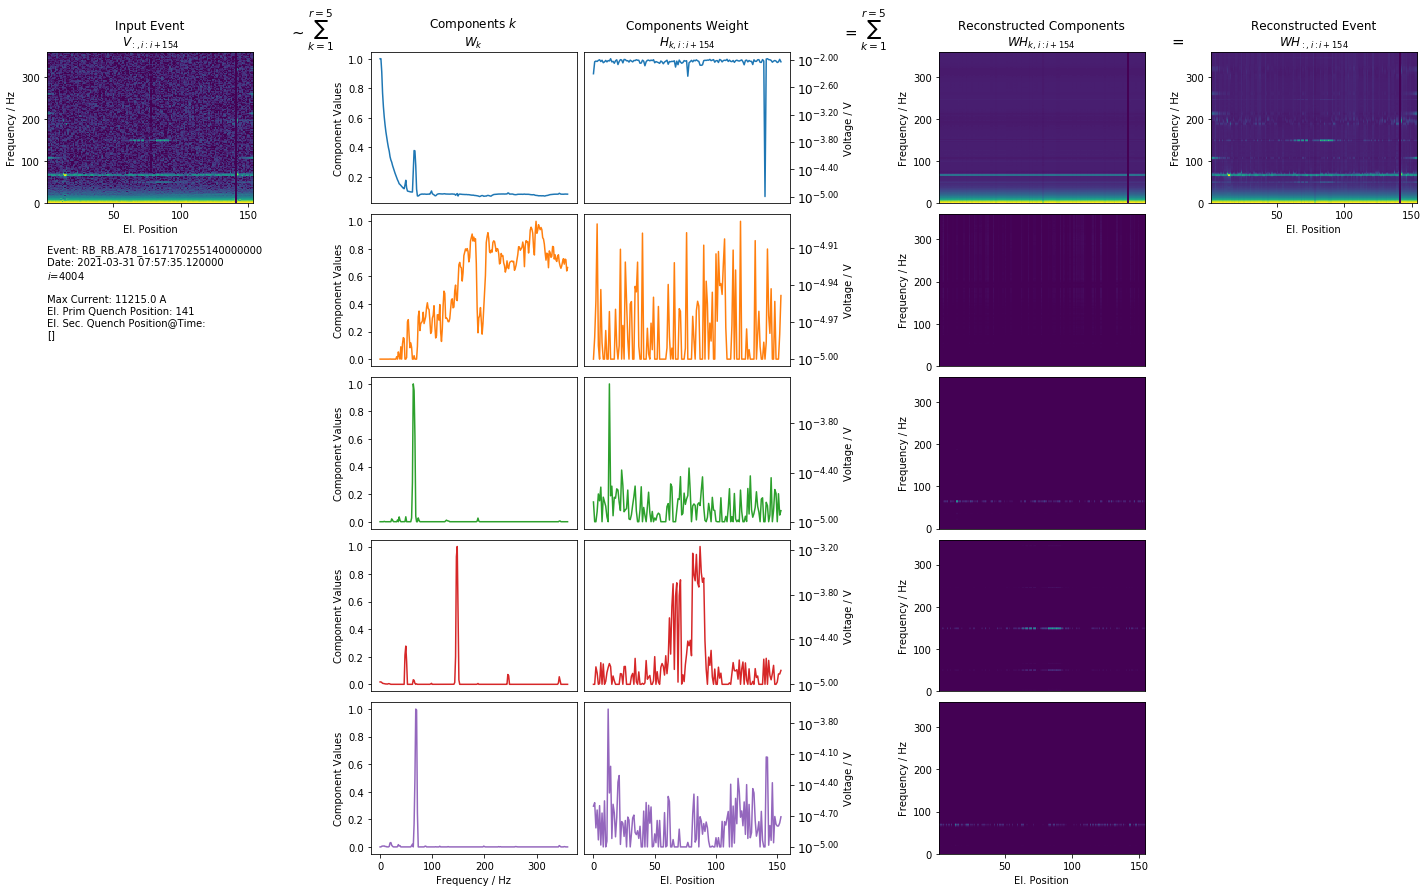

In [21]:
component_indexes_2EE = [0,1,2,3,4]
plot_nmf_event_composition(data_2EE, component_weights_2EE, H_2EE_processed, component_indexes_2EE, dataset_2EE_fft, fpa_identifier, mp3_fpa_df)

### Distribution of Component weights

In [22]:
component_weights_2EE_reshaped = component_weights_2EE.copy().reshape(-1, 154, len(merge_component_index))

c_weights_dict_2EE = generate_sorted_value_dict(values=component_weights_2EE_reshaped, df_pos_map=df_pos_map, df_event_context=mp3_fpa_df_pos_subset)

El. Position
Phys. Position
Phys. Position ODD
Phys. Position EVEN
Phys. Dist. to PC
Phys. Dist. to Quench
El. Dist. to Quench Main
El. Dist. to Quench Mirror


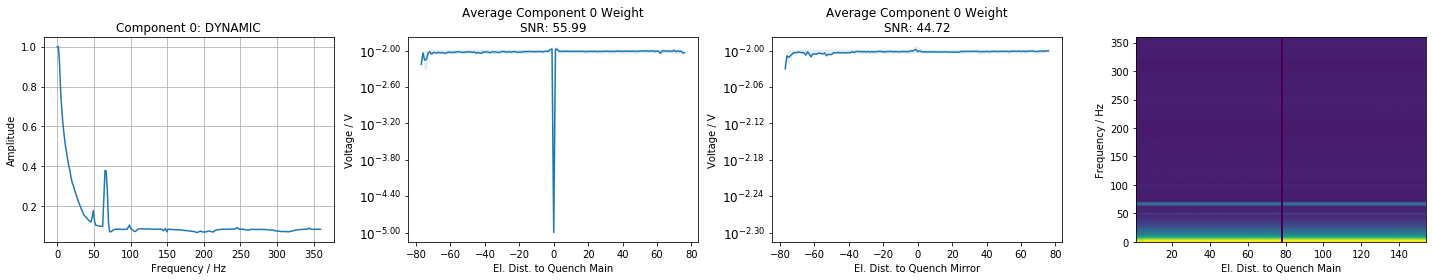

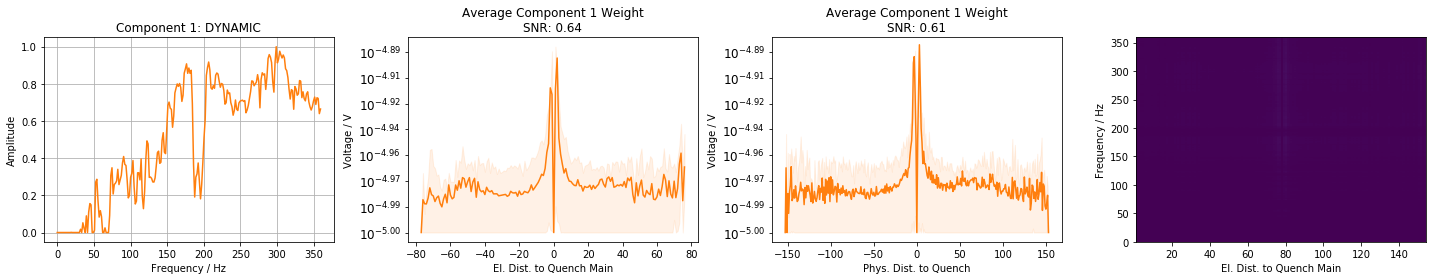

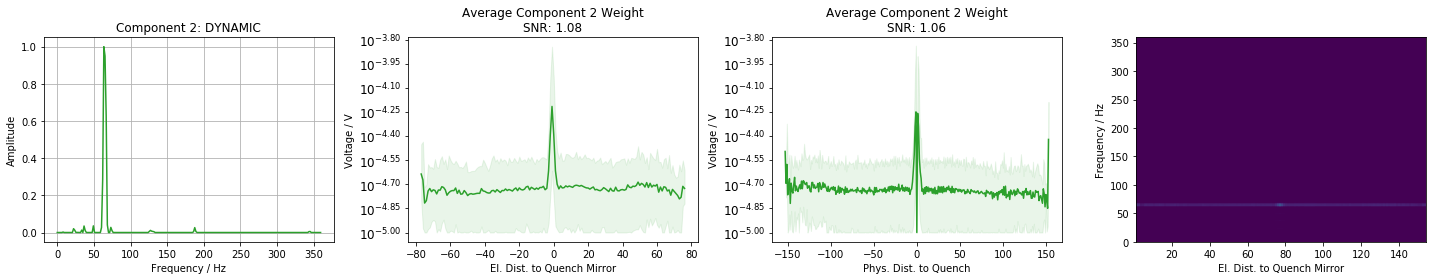

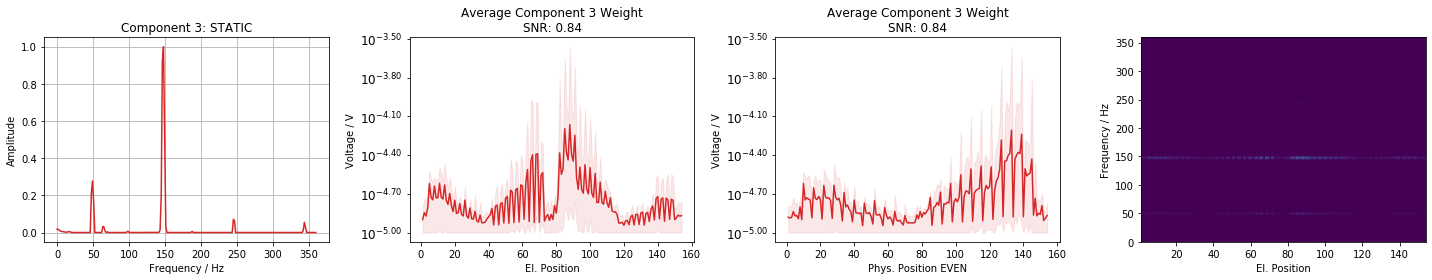

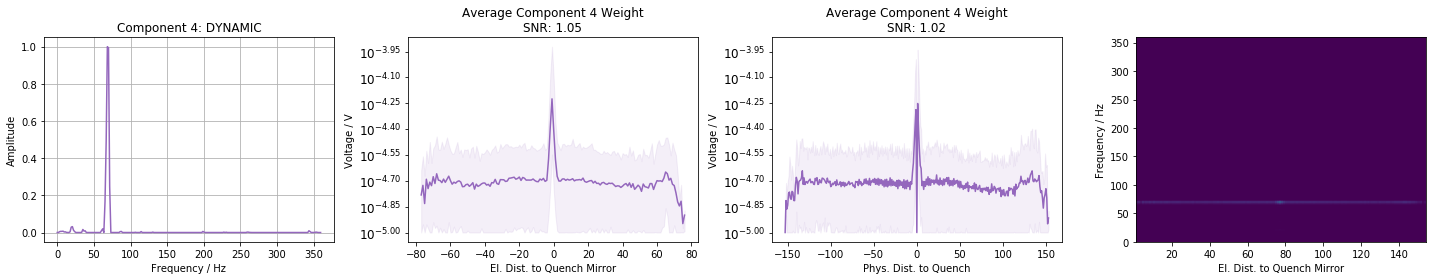

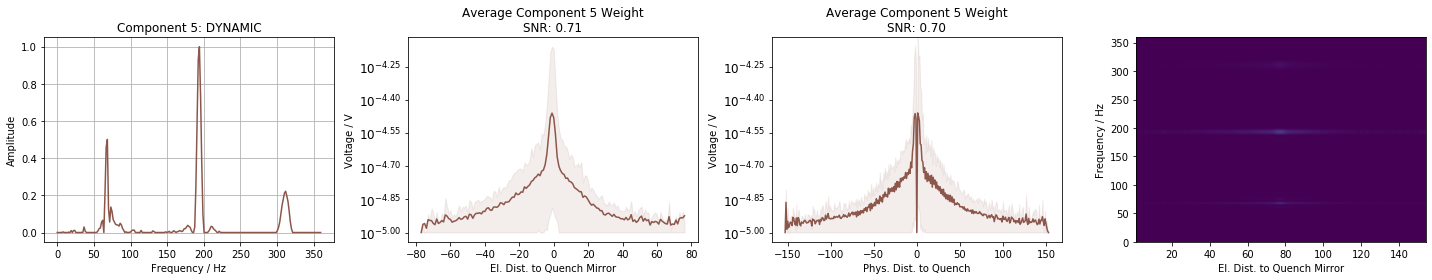

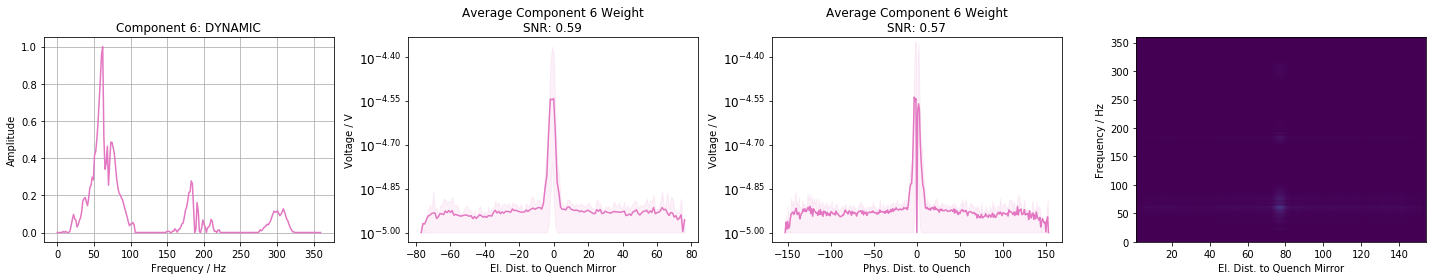

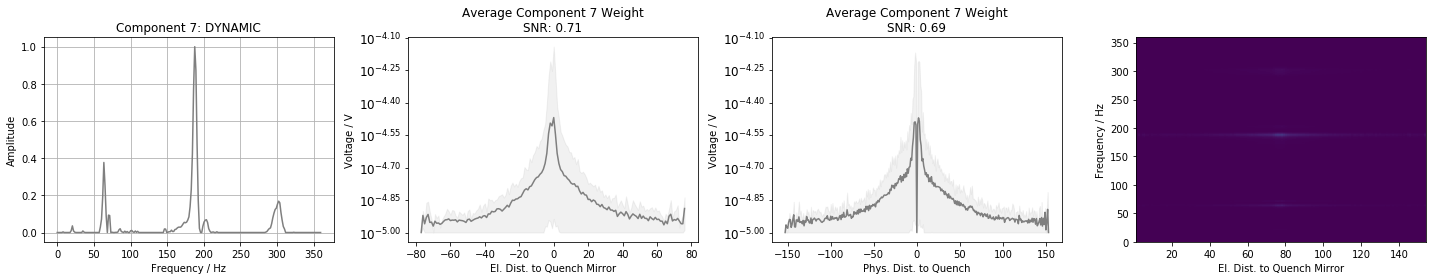

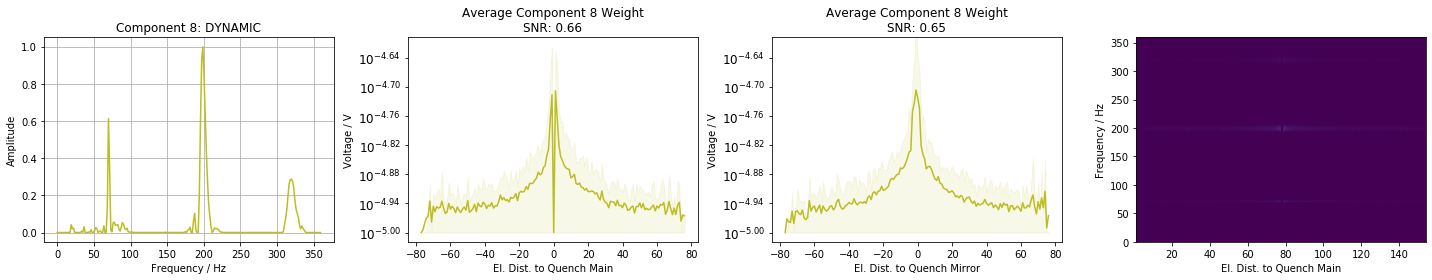

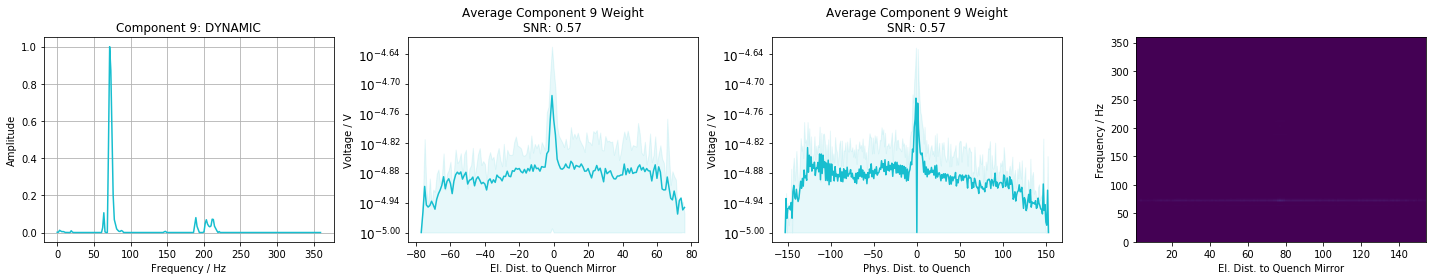

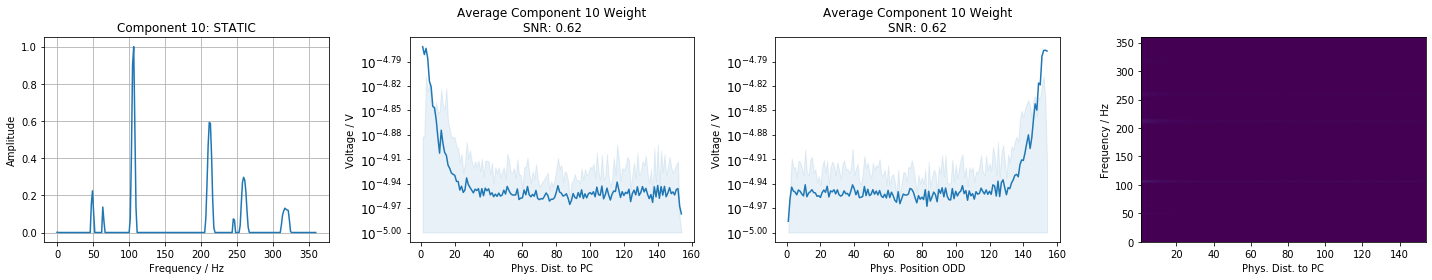

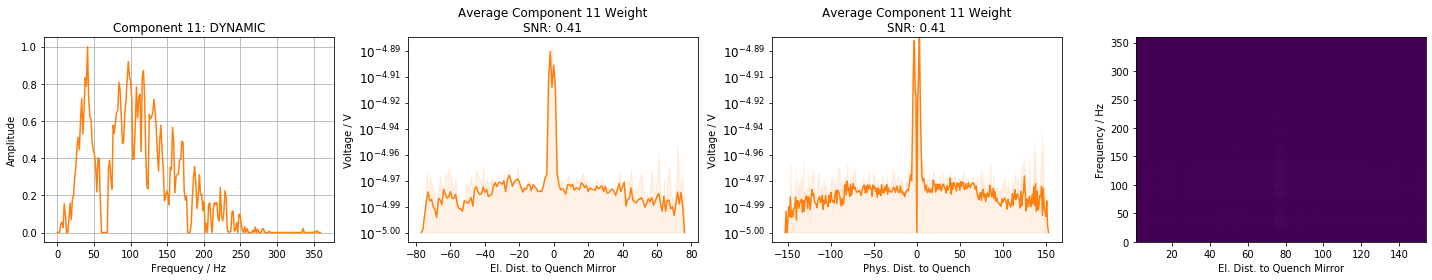

In [23]:
plot_n_highest_snr =  2#len(c_weights_dict_2EE)
n_components = c_weights_dict_2EE["El. Position"]["values"].shape[-1]
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] * 2

best_sort_index_2EE = []
for k in range(n_components): 
    
    snr_sorted_index = np.argsort([-c_weights_dict_2EE[sort]["snr"][k] for sort in c_weights_dict_2EE])[:plot_n_highest_snr]
    best_sort_index_2EE.append(snr_sorted_index[0])
    
    fig, ax = plt.subplots(1,plot_n_highest_snr+2, figsize =(5*(plot_n_highest_snr+2),4))
    ax[0].plot(dataset_2EE_fft.frequency, H_2EE_processed[k], c=default_colors[k % n_components])
    ax[0].set_title(f"Component {k}")
    ax[0].set_xlabel("Frequency / Hz")
    ax[0].set_ylabel("Amplitude")
    ax[0].grid()
    
    if "Quench" in list(c_weights_dict_2EE)[snr_sorted_index[0]]:
        ax[0].set_title(f"Component {k}: DYNAMIC")
    else:
        ax[0].set_title(f"Component {k}: STATIC")
    
    for i, sort in enumerate(np.array(list(c_weights_dict_2EE))[snr_sorted_index]):
        plot_avg_component_weight(ax[i+1], c_weights_dict_2EE[sort], component_number=k, xlabel=sort)
        
        yticks = ax[i+1].get_yticks().tolist()
        
        ax[i+1].set_yticklabels([f"$10^{{{(3*a-5):.2f}}}$" for a in yticks], fontsize="large")
        ax[i+1].set_ylabel("Voltage / V")
        ax[i+1].set_ylim(ax[1].get_ylim())

    
    best_sort = list(c_weights_dict_2EE)[snr_sorted_index[0]]
    V_mean = np.nanmean(c_weights_dict_2EE[best_sort]["values"], axis=0)[:, k:k+1] @  H_2EE_processed[k:k+1]
    plot_position_frequency_map(ax[-1], V_mean, dataset_2EE_fft.frequency, norm=None, vmin=0, vmax=1)
    ax[-1].set_xlabel(best_sort)
    ax[-1].set_ylabel("Frequency / Hz")
    
    plt.tight_layout()

In [ ]:
n_quench_pos = 154
V_mean_2EE = np.zeros((n_quench_pos,) + dataset_2EE_fft.shape[1:])
for quench_pos in range(n_quench_pos):

    for i_component, i_best_sort in enumerate(best_sort_index_2EE):
        best_sort = list(c_weights_dict_2EE)[i_best_sort]
        V_mean = np.nanmean(c_weights_dict_2EE[best_sort]["values"], axis=0)[:, i_component:i_component+1] @  H_2EE_processed[i_component:i_component+1]

        if "Main" in list(c_weights_dict_2EE)[i_best_sort]:
            V_mirror = np.nanmean(c_weights_dict_2EE['El. Dist. to Quench Mirror']["values"], axis=0)[:, i_component:i_component+1] @  H_2EE_processed[i_component:i_component+1]
            V_mean = main_mirror_to_el(V_mean, V_mirror, quench_pos)
        elif "Mirror" in list(c_weights_dict_2EE)[i_best_sort]:
            V_main = np.nanmean(c_weights_dict_2EE['El. Dist. to Quench Main']["values"], axis=0)[:, i_component:i_component+1] @  H_2EE_processed[i_component:i_component+1]
            V_mean = main_mirror_to_el(V_main, V_mean, quench_pos)

        elif "Quench" in list(c_weights_dict_2EE)[i_best_sort]:
            center = int(len(V_mean) /2)
            V_mean = np.roll(V_mean, -center +quench_pos, axis=0)
        V_mean_2EE[quench_pos] += V_mean

# Simulate FP-map given components for both EE

In [ ]:
output_path = Path(f"../output/nmf_decomposition.py/simulation_all")
output_path.mkdir(parents=True, exist_ok=True)

im_paths = []   
circuit = 'RB.A12'
for quench_pos in range(n_quench_pos):
    phys_pos_index = map_position_index(df_pos_map, origin="El. Position", to='Phys. Position', filt={'Circuit': circuit, 'El. Quench Position': quench_pos})
    phys_quench_pos = map_position_index(df_pos_map, old_index=[quench_pos], origin="Phys. Position", to='El. Position', filt={'Circuit': 'RB.A12', 'El. Quench Position': quench_pos})[0]
    
    fig, ax = plt.subplots(2,3, figsize = (15,10), gridspec_kw={ 'width_ratios': [4, 4, 1]})
    
    plot_position_frequency_map(ax[0, 0], V_mean_1EE[quench_pos], dataset_1EE_fft.frequency, norm=None, vmin=0, vmax=1) 
    ax[0, 0].set_title(f"U_Diode @ 1st EE, El. Quench Position: {quench_pos+1}")
    ax[0, 0].set_ylabel("Frequency / Hz")
    ax[0, 0].set_xlabel("El. Position")
    
    im = plot_position_frequency_map(ax[0, 1], V_mean_1EE[quench_pos][phys_pos_index], dataset_1EE_fft.frequency, norm=None, vmin=0, vmax=1) 
    ax[0, 1].set_title(f"{circuit}, Phys. Quench Position: {phys_quench_pos+1}")
    ax[0, 1].set_ylabel("Frequency / Hz")
    ax[0, 1].set_xlabel("Phys. Position")
    
    plot_position_frequency_map(ax[1, 0], V_mean_2EE[quench_pos], dataset_1EE_fft.frequency, norm=None, vmin=0, vmax=1) 
    ax[1, 0].set_title(f"U_Diode @ 2nd EE, El. Quench Position: {quench_pos}")
    ax[1, 0].set_ylabel("Frequency / Hz")
    ax[1, 0].set_xlabel("El. Position")
    
    plot_position_frequency_map(ax[1, 1], V_mean_2EE[quench_pos][phys_pos_index], dataset_1EE_fft.frequency, norm=None, vmin=0, vmax=1) 
    ax[1, 1].set_title(f"{circuit}, Phys. Quench Position: {phys_quench_pos+1}")
    ax[1, 1].set_ylabel("Frequency / Hz")
    ax[1, 1].set_xlabel("Phys. Position")
    
    cbar = fig.colorbar(im, ax=ax[0, 2], fraction=1)
    ax[0, 2].set_axis_off()
    cticks = cbar.get_ticks().tolist()
    cbar.set_ticks(cticks)
    cbar.set_ticklabels([f"$10^{{{(3*a-5):.2f}}}$" for a in cticks])
    cbar.set_label("Voltage / V")
    cbar.ax.tick_params(labelsize=12)
    
    cbar = fig.colorbar(im, ax=ax[1, 2], fraction=1)
    ax[1, 2].set_axis_off()
    cticks = cbar.get_ticks().tolist()
    cbar.set_ticks(cticks)
    cbar.set_ticklabels([f"$10^{{{(3*a-5):.2f}}}$" for a in cticks])
    cbar.set_label("Voltage / V")
    cbar.ax.tick_params(labelsize=12)

    im_path = output_path / f"{quench_pos+1}.png"
    im_paths.append(im_path)
    plt.tight_layout()
    plt.savefig(im_path)
    plt.close(fig)

In [ ]:
from PIL import Image
imgs = (Image.open(f) for f in im_paths)
img = next(imgs)  # extract first image from iterator
img.save(fp=output_path / "summary.gif", format='GIF', append_images=imgs, save_all=True, duration=100, loop=0)